In [1]:
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###An on-axis guide star and the GMT telescope model

In [2]:
nPx = 256
D = 25.5
src    = ceo.Source("R",rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=10,M2_radial_order=10)

The source is propagated to the exit pupil plane conjugated to M1 and the wavefront is displayed.

<matplotlib.colorbar.Colorbar instance at 0x2abd9006cf38>

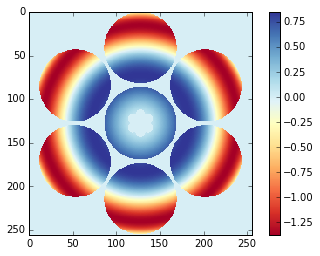

In [3]:
src.reset()
gmt.propagate(src)
imshow(src.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
colorbar()

The wavefront error rms is

In [4]:
src.wavefront.rms()*1e9

array([ 0.79138786], dtype=float32)

The segment piston are 

In [5]:
src.wavefront.piston(mask=gmt.M1.piston_mask)*1e9

array([-0.29249012, -0.29323661, -0.29323408, -0.29248694, -0.29323521,
       -0.29323578,  0.45804355], dtype=float32)

### Ray tracing
The `ray_trace` function has the following parameters:
* GMT mirrors: 'M1' of 'M2'
* zenith angle of the guide star in arcmin
* azimuth angle of the guide star in degree
* Tx,Ty and Tz: the x, y and z axis translation of a segment in micron
* Rx, Ry and Rz: the x, y and z axis rotation angle of a segment in mas
* zmode, the Zernike mode
* zstroke, the stroke of the Zernike mode in micron
* segId, the segment number according to GMT nomenclature
* overlay: False(0) means the telescope is reset to its original prescription before applying perturbing a segment and True(1) compounds the pertubations

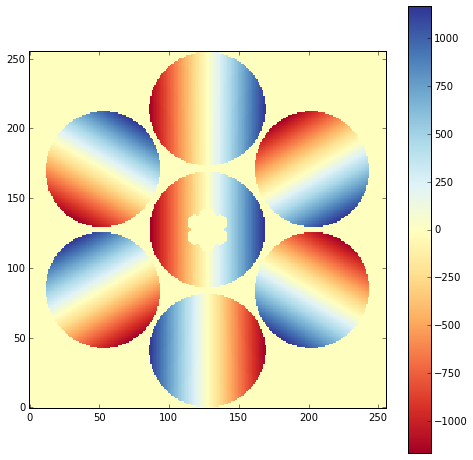

In [6]:
def ray_trace(mirror='M1',zenith=0.0,azimuth=0.0,Tx=0.0,Ty=0.0,Tz=0.0,Rx=0.0,Ry=0.0,Rz=0.0,
              zmode=0,zstroke=0,segId=0,overlay=False):
        
    mu = 1e-6
    mas2rad = 1e-3*math.pi/180/3600
    
    T = [Tx*mu,Ty*mu,Tz*mu]
    R = [Rx*mas2rad,Ry*mas2rad,Rz*mas2rad]
    
    if not overlay:
        gmt.reset()
    if mirror=="M1":
        gmt.M1.update(origin=T,euler_angles=R,idx=segId)
        gmt.M1.zernike.a[segId-1,zmode-1] = zstroke*mu
        gmt.M1.zernike.update()
    if mirror=="M2":
        gmt.M2.update(origin=T,euler_angles=R,idx=segId)
        gmt.M2.zernike.a[segId-1,zmode-1] = zstroke*mu
        gmt.M2.zernike.update()

    src    = ceo.Source("R",zenith=60*zenith*math.pi/180/3600,azimuth=azimuth*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
    gmt.propagate(src)

    fig = figure()
    fig.set_size_inches(8,8)
    imshow(src.phase.host(units='nm'),interpolation='None',origin='lower',cmap='RdYlBu')
    colorbar()
    
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display
Txyz = (-10.0,10.0) # micron
Rxyz = (-100.0,100.0) # mas
i = interact(ray_trace,mirror=['M1','M2'],
             zenith=(0.0,5.0),azimuth=(0,360),
             Tx=Txyz,Ty=Txyz,Tz=Txyz,Rx=Rxyz,Ry=Rxyz,Rz=Rxyz,
             zmode=(1,66),zstroke=(-4.0,4.0),segId=(1,7),overlay=[False,True])
